In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import copy
%matplotlib inline
import os
import glob

## First download the preprocessed H3.6m Dataset

The dataset is downloaded to [data/h3.6m](data/h3.6m).

In [ ]:
if not os.path.exists('data'):
    os.mkdir('data')
os.chdir('data')
os.system('svn checkout https://github.com/BII-wushuang/Lie-Group-Motion-Prediction/trunk/src/data/h3.6m/')
os.chdir('../')

## Preliminaries

Below we define a class for a skeleton. It will be initialized with the skeletal offsets as well as a kinematic tree (the different kinematic chains in the skeleton).

The base skeletal offsets characterizes the default human pose, with no rotations at any joint.

## Inverse and Forward kinematics
We denote by $R$ the rotation matrix and $T$ the translation vector associated with a bone. In particular, the translation matrix for each joint is exactly given by the skeletal offset vector. Joint locations are denoted by $j$.

The fundamental kinematic chain equation is the following:
$$\left(\begin{matrix}R_0 & T_0 \\ 0 & 1\end{matrix}\right)\cdots\left(\begin{matrix}R_{n} & T_{n} \\ 0 & 1\end{matrix}\right)\left(\begin{matrix} 0 \\ 1\end{matrix}\right) = \left(\begin{matrix} j_n \\ 1\end{matrix}\right)$$
which is equivalent to the following:
$$j_n = R_0\cdots R_{n-1} T_n + j_{n-1}.$$

With the above, we are ready to implement the inverse and forward kinematics functions.

In [3]:
def RtoLie(R):
    '''Returns the axis angle aka lie algebra parameters from a rotation matrix'''
    theta = np.arccos((np.trace(R) - 1) / 2.0)
    if theta < 1e-6:
        A = np.zeros(3)
    else:
        A = theta / (2 * np.sin(theta)) * np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
    return A

def LietoR(A):
    '''Returns the rotation matrix from lie algebra parameters'''
    theta = np.linalg.norm(A)
    if theta == 0:
        R = np.identity(3)
    else:
        A = A / theta
        cross_matrix = np.array([[0, -A[2], A[1]], [A[2], 0, -A[0]], [-A[1], A[0], 0]])
        R = np.identity(3) + np.sin(theta) * cross_matrix + (1 - np.cos(theta)) * np.matmul(cross_matrix, cross_matrix)
    return R

def findrot(u, v):
    '''find the axis angle parameters to rotate unit vector u onto unit vector v'''
    w = np.cross(u, v)
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-6:
        A = np.zeros(3)
    else:
        A = w / w_norm * np.arccos(np.dot(u, v))
    return A

def eulertoR(angle):
    '''Returns the rotation matrix from euler angle parameters'''
    a = angle[0]
    b = angle[1]
    c = angle[2]

    a1 = np.array([1, 0, 0])
    a2 = np.array([0, np.cos(a), -np.sin(a)])
    a3 = np.array([0, np.sin(a), np.cos(a)])

    A = np.array([a1, a2, a3])

    b1 = np.array([np.cos(b), 0, np.sin(b)])
    b2 = np.array([0, 1, 0])
    b3 = np.array([-np.sin(b), 0, np.cos(b)])

    B = np.array([b1, b2, b3])

    c1 = np.array([np.cos(c), -np.sin(c), 0])
    c2 = np.array([np.sin(c), np.cos(c), 0])
    c3 = np.array([0, 0, 1])

    C = np.array([c1, c2, c3])

    R = np.matmul(np.matmul(A, B), C)

    return R

class Skeleton:
    def __init__(self, kinematic_tree, offsets, parents):
        # We first define the skeleton for H3.6m
        self._kinematic_tree = kinematic_tree
        self._offsets = offsets
        self._njoints = offsets.shape[0]
        self._raw_offsets = copy.deepcopy(offsets)
        for i in range(self._njoints):
            n = np.linalg.norm(self._raw_offsets[i])
            if n > 0:
                self._raw_offsets[i] = self._raw_offsets[i]/n
        
        self._parents = parents
                
    def njoints(self):
        return self._njoints
    
    def kinematic_tree(self):
        return self._kinematic_tree

    def raw_offsets(self):
        return self._raw_offsets
    
    def offsets(self):
        return self._offsets
        
    def parents(self):
        return self._parents
    
    def get_bonelengths(self, joints):
        '''This adjusts the bone lengths according to the joints'''
        for i in range(1, len(self._raw_offsets)):
            self._offsets[i] = np.linalg.norm(joints[i] - joints[self._parents[i]]) * self._raw_offsets[i]
    
#     def inverse_kinematics(self, joints):
#         lie_params = np.zeros([self._njoints, 3])
#         for chain in self._kinematic_tree:
#             R = np.eye(3)
#             for j in range(len(chain)-1):
#                 u = self._raw_offsets[chain[j+1]]
#                 v = joints[chain[j+1]]-joints[chain[j]]
#                 v = v / np.linalg.norm(v)
#                 R_local = np.matmul(np.transpose(R), LietoR(findrot(u,v)))
#                 lie_params[chain[j+1]] = RtoLie(R_local)
#                 R = np.matmul(R, R_local)
#         return lie_params
    
    def forward_kinematics(self, lie_params):
        joints = np.zeros([self._njoints, 3])
        R = np.zeros([self._njoints, 3, 3])
        for i in range(self._njoints):
            if self._parents[i] == -1:  # Root node
                R[i] = np.eye(3)
            else:
                joints[i] = self._offsets[i].dot(R[self._parents[i]]) + joints[self._parents[i]]
                R[i] = LietoR(lie_params[i]).dot(R[self._parents[i]])
        return joints
    
    def forward_kinematics_euler(self, angles):
        joints = np.zeros([self._njoints, 3])
        angles = np.reshape(angles, [self._njoints, 3])
        R = np.zeros([self._njoints, 3, 3])
        for i in range(self._njoints):
            if self._parents[i] == -1:  # Root node
                R[i] = np.eye(3)
            else:
                joints[i] = self._offsets[i].dot(R[self._parents[i]]) + joints[self._parents[i]]
                R[i] = eulertoR(angles[i]).dot(R[self._parents[i]])
        return joints
    
    def plot(self, joints):
        plt.figure()
        limits = 1200
        ax = plt.axes(xlim=(-limits,limits), ylim=(-limits,limits), zlim=(-limits,limits), projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=120, azim=-90)
        ax.scatter(joints[:,0], joints[:,1], joints[:,2], color='black')
        colors = ['red', 'yellow', 'black', 'green', 'blue']
        for chain, color in zip(self._kinematic_tree, colors):
            ax.plot3D(joints[chain,0], joints[chain,1], joints[chain,2], linewidth=2.0, color=color)


## Initialze Skeleton class with following parameters

In [4]:
# Define a kinematic tree for the skeletal struture
# Left leg, Right leg, Spine, Left arm, Right arm
kinematic_tree = [[0, 1, 2, 3, 4, 5], [0, 6, 7 ,8, 9, 10], [0, 12, 13, 14, 15], [13, 17, 18, 19, 22, 19, 21], [13, 25, 26, 27, 30, 27, 29]]
parents = np.array([-1,  0,  1,  2,  3,  4,  0,  6,  7,  8,  9,  0, 11, 12, 13, 14, 12, 16, 17, 18, 19, 20, 19, 22, 12, 24, 25, 26, 27, 28, 27, 30])
offsets = np.array([[0., 0., 0.],
                   [-132.95, 0., 0.],
                   [0., -442.89, 0.],
                   [0., -454.21, 0.],
                   [0., 0., 162.77],
                   [0., 0., 75.],
                   [132.95, 0., 0.],
                   [0., -442.89, 0.],
                   [0., -454.21, 0.],
                   [0., 0., 162.77],
                   [0., 0., 75.],
                   [0., 0., 0.],
                   [0., 233.38, 0.],
                   [0., 257.08, 0.],
                   [0., 121.13, 0.],
                   [0., 115., 0.],
                   [0., 257.08, 0.],
                   [0., 151.03, 0.],
                   [0., 278.88, 0.],
                   [0., 251.73, 0.],
                   [0., 0., 0.],
                   [0., 0., 100.],
                   [0., 137.5, 0.],
                   [0., 0., 0.],
                   [0., 257.08, 0.],
                   [0., 151.03, 0.],
                   [0., 278.88, 0.],
                   [0., 251.73, 0.],
                   [0., 0., 0.],
                   [0., 0., 100.],
                   [0., 137.5, 0.],
                   [0., 0., 0.]])
human_skel = Skeleton(kinematic_tree, offsets, parents)


## Load a sample 3D pose and plot

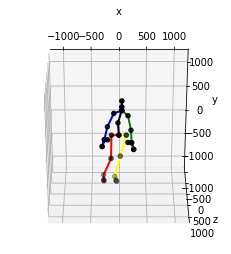

In [6]:
data = sio.loadmat('Data/h3.6m/Train/train_xyz/S1_directions_1_xyz.mat')['joint_xyz']
# data = sio.loadmat('SMPL/walking_0.mat')['prediction']
frame = 0
joints_xyz = np.reshape(data[frame], [32,3])
# We need to switch the y and z axis
joints_xyz = joints_xyz[:,[0,2,1]]
human_skel.plot(joints_xyz)

## Load the same pose parameterized in lie parameters

We apply forward kinematics and plot this pose.

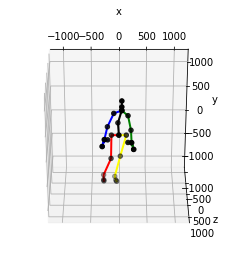

In [7]:
data = sio.loadmat('Data/h3.6m/Train/train_lie//S1_directions_1_lie.mat')['lie_parameters']
frame = 0
lie_params = np.reshape(data[frame][3:], [32,3])
joints_fwd = human_skel.forward_kinematics(lie_params)
human_skel.plot(joints_fwd)

## PyTorch Implementation
In the following, we define the functions for exponentiating lie parameters to rotation matrices as well the forward kinematics process in PyTorch.

In [8]:
import torch
from torch.autograd.variable import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parents = np.array([-1,  0,  1,  2,  3,  4,  0,  6,  7,  8,  9,  0, 11, 12, 13, 14, 12, 16, 17, 18, 19, 20, 19, 22, 12, 24, 25, 26, 27, 28, 27, 30])
offsets = np.array([[0., 0., 0.],
                   [-132.95, 0., 0.],
                   [0., -442.89, 0.],
                   [0., -454.21, 0.],
                   [0., 0., 162.77],
                   [0., 0., 75.],
                   [132.95, 0., 0.],
                   [0., -442.89, 0.],
                   [0., -454.21, 0.],
                   [0., 0., 162.77],
                   [0., 0., 75.],
                   [0., 0., 0.],
                   [0., 233.38, 0.],
                   [0., 257.08, 0.],
                   [0., 121.13, 0.],
                   [0., 115., 0.],
                   [0., 257.08, 0.],
                   [0., 151.03, 0.],
                   [0., 278.88, 0.],
                   [0., 251.73, 0.],
                   [0., 0., 0.],
                   [0., 0., 100.],
                   [0., 137.5, 0.],
                   [0., 0., 0.],
                   [0., 257.08, 0.],
                   [0., 151.03, 0.],
                   [0., 278.88, 0.],
                   [0., 251.73, 0.],
                   [0., 0., 0.],
                   [0., 0., 100.],
                   [0., 137.5, 0.],
                   [0., 0., 0.]])


def LietoR_torch(A):
    '''
    Returns the rotation matrices from lie algebra parameters
    pytorch version
    :param A: njoints*3
    :return R: njoints*3*3 
    '''
    theta = torch.norm(A, 2, 1)
    r0 = torch.div(A, theta.unsqueeze(1).repeat(1, 3) + 0.0000001)
    r1 = torch.zeros_like(r0).repeat(1, 3)
    r1[:, 1] = -r0[:, 2]
    r1[:, 2] = r0[:, 1]
    r1[:, 5] = -r0[:, 0]
    r1 = r1.view(-1, 3, 3)
    r1 = r1 - r1.transpose(1, 2)
    n = r1.data.shape[0]
    R = Variable(torch.eye(3, 3).repeat(n, 1, 1)).float().to(device) \
        + torch.mul(torch.sin(theta).unsqueeze(1).repeat(1, 9).view(-1, 3, 3), r1) \
        + torch.mul((1 - torch.cos(theta).unsqueeze(1).repeat(1, 9).view(-1, 3, 3)), torch.matmul(r1, r1))
    return R


def forward_kinematics_torch(lie_params, parents, offsets):
    '''
    Returns the joint positions from lie algebra parameters
    pytorch version
    :param lie_params: njoints*3
    :param parents
    :param offsets
    :return joints: njoints*3
    '''
    njoints = offsets.shape[0]    
    joints = Variable(torch.from_numpy(offsets)).float().to(device)
    R = LietoR_torch(lie_params).view(njoints, 3, 3)
    for i in np.arange(1, njoints):
        R[i, :, :] = torch.matmul(R[i, :, :], R[parents[i], :, :]).clone()
        joints[i, :] = torch.matmul(joints[i, :], R[parents[i], :, :]) + joints[parents[i], :]
    return joints


In [9]:
lie_params_torch = torch.from_numpy(lie_params).to(device)
joints_torch = forward_kinematics_torch(lie_params_torch, parents, offsets)
human_skel.plot(joints_torch.cpu().numpy())

RuntimeError: CUDA error: out of memory

In [419]:
def normalize_vector(v):
    v_mag = torch.sqrt(v.pow(2).sum(1))
    v_mag = torch.max(v_mag, Variable(torch.FloatTensor([1e-8]).to(device)))
    v_mag = v_mag.view(-1, 1).expand(v.shape[0], v.shape[1])
    v = v / v_mag
    return v


def cross_product(u, v):
    i = u[:, 1] * v[:, 2] - u[:, 2] * v[:, 1]
    j = u[:, 2] * v[:, 0] - u[:, 0] * v[:, 2]
    k = u[:, 0] * v[:, 1] - u[:, 1] * v[:, 0]

    out = torch.cat((i.view(-1,1), j.view(-1,1), k.view(-1,1)),1)
    return out

def stiefeltoRotation(params):
    R1_raw = params[:, 0:3]
    R2_raw = params[:, 3:6]

    R1 = normalize_vector(R1_raw)
    R2 = normalize_vector(R2_raw)
#     R3 = cross_product(R1, R2_raw)
#     R3 = normalize_vector(R3)
    R3 = cross_product(R1, R2)

    R1 = R1.view(-1, 3, 1)
    R2 = R2.view(-1, 3, 1)
    R3 = R3.view(-1, 3, 1)
    R = torch.cat((R1, R2, R3), 2)

    return R

In [448]:
def geodesic(R1, R2):
    batch=R1.shape[0]
    # arccos [(Tr(R1R2^T)-1)/2]
    
    R = torch.bmm(R1, R2.transpose(1,2)) #batch*3*3
    cos = (R[:,0,0] + R[:,1,1] + R[:,2,2] - 1) / 2
    cos = torch.min(cos, Variable(torch.ones(batch).to(device)))
    cos = torch.max(cos, Variable(torch.ones(batch).to(device))*-1)
    theta = torch.abs(torch.acos(cos))
    
    return theta

In [438]:
def LietoR(A):
    '''
    Returns the rotation matrices from lie algebra parameters
    :param A: njoints*3
    :return R: njoints*3*3 
    '''
    njoints = A.shape[0]
    theta = np.linalg.norm(A, 2, 1)
    theta[theta == 0] = 1e-8
    omega = np.divide(A, theta.repeat(3).reshape(-1,3))
    omega_cross = np.zeros_like(omega).repeat(3, axis=1)
    omega_cross[:, 1] = -omega[:, 2]
    omega_cross[:, 2] = omega[:, 1]
    omega_cross[:, 5] = -omega[:, 0]
    omega_cross = omega_cross.reshape([-1,3,3])
    omega_cross = omega_cross - omega_cross.transpose([0, 2, 1])
    R = np.tile(np.eye(3, 3), [njoints,1,1]) + np.multiply(np.sin(theta).repeat(9).reshape([-1,3,3]), omega_cross) + np.multiply((1-np.cos(theta)).repeat(9).reshape([-1,3,3]), np.matmul(omega_cross, omega_cross))
    return R


def LietoStiefel(A):
    '''
    Returns the Stiefel manifold parameters from lie algebra parameters
    :param A: nframes*njoints*3
    :return S: nframes*(njoints*6)
    '''
    nframes = A.shape[0]
    A = A.reshape([-1, 3])
    R = LietoR(A)
    S = R[:,:,:2].transpose([0,2,1]).reshape([nframes, -1])
    return S

In [283]:
def convertStiefel(data):
    nframes = data.shape[0]
    stiefel = np.zeros([nframes, 90])
    stiefel[:,0:6] = data[:, dim_single]
    stiefel[:,6:] = LietoStiefel(data[:,dim_triple].reshape(nframes, -1, 3))
    
    return stiefel

In [461]:
def fk_stiefel(stiefel, parents, offsets):
    '''
    Returns the joint positions from stiefel parameters
    pytorch version
    :param stiefel
    :param parents
    :param offsets
    :return joints: njoints*3
    '''
    njoints = offsets.shape[0]    
    joints = Variable(torch.from_numpy(offsets)).float().to(device)
    
    s = torch.from_numpy(stiefel).float().to(device)
    R = torch.eye(3).repeat(njoints,1,1).float().to(device)
    A = torch.cat([s[0].unsqueeze(1), torch.zeros([6,2]).to(device)], axis=1)
    R_A = LietoR_torch(A)
    for i, idx in enumerate(single_idx):
        R[idx] = R_A[i]
    R_S = stiefeltoRotation(s[1:])
    for i, idx in enumerate(stiefel_idx):
        R[idx] = R_S[i]
    for i in np.arange(1, njoints):
        R[i, :, :] = torch.matmul(R[i, :, :], R[parents[i], :, :]).clone()
        joints[i, :] = torch.matmul(joints[i, :], R[parents[i], :, :]) + joints[parents[i], :]
    return joints

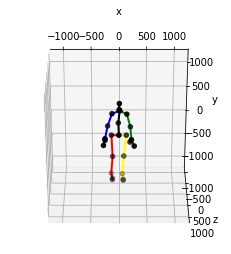

In [462]:
S = convertStiefel(data)
s = S[0].reshape(-1,6)
joints_fwd = fk_stiefel(s, parents, offsets)
human_skel.plot(joints_fwd.cpu().numpy())

In [456]:
dim_single = [9,15,24,30,57,81]
dim_triple = [6,7,8,12,13,14] + [21,22,23,27,28,29] + [x for x in range(36,48)] + [51,52,53,54,55,56,60,61,62] + [75,76,77,78,79,80,84,85,86]
single_idx = np.array(dim_single) // 3 - 1
stiefel_idx = np.array(dim_triple).reshape([-1,3])[:,0]//3 - 1